## Define the Models and the Necessary Functions

In [1]:
import math
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
class UnigramModel:
    def __init__(self, unigram_freq, total_unigrams):
        self.unigram_freq = unigram_freq
        self.total_unigrams = total_unigrams
        self.add_k = 0

    def set_addk(self, k):
        self.add_k = k

    def probability(self, unigram):
        # check if ngram is a single word or two word
        word_list = unigram.split(" ")
        if len(word_list) != 1:
            raise Exception("Unigram probability needs one word exactly.")

        # return probability
        unigram_count = self.unigram_freq.get(word_list[0], self.unigram_freq.get('<UNK>', 0))
        V = len(self.unigram_freq.keys())

        # this is using smoothing formula (but if add_k is 0 then it will act as unsmoothed version)
        p = (unigram_count + self.add_k) / (self.total_unigrams + self.add_k * V)

        return p

    def ppl(self, test_tokens, total_tokens):
        log_prob_sum = 0
        # we are doing log calculations to avoid underflow of value
        for unigram in test_tokens:
            p = self.probability(unigram)
            if p > 0:
                log_prob_sum += math.log(p)
            else:
                raise Exception("Zero probability encountered! Apply unknown word handling")

        return math.exp(-1 * log_prob_sum / total_tokens)


class BigramModel:
    def __init__(self, bigram_freq, total_bigrams, unigram_model):
        self.unigram_model = unigram_model
        self.bigram_freq = bigram_freq
        self.total_bigrams = total_bigrams
        self.add_k = 0

    def set_addk(self, k):
        self.add_k = k

    def probability(self, bigram):
        # check if ngram is a single word or two word
        word_list = bigram.split(" ")
        if len(word_list) != 2:
            raise Exception("Bigram probability needs two words exactly.")

        # handle unknown
        if word_list[0] not in self.unigram_model.unigram_freq:
            word_list[0] = "<UNK>"
        if word_list[1] not in self.unigram_model.unigram_freq:
            word_list[1] = "<UNK>"

        bigram = " ".join(word_list)

        # return probability
        bigram_count = self.bigram_freq.get(bigram, 0)
        unigram_count = self.unigram_model.unigram_freq.get(word_list[0], 0)
        V = len(self.unigram_model.unigram_freq.keys())

        # this is using smoothing formula (but if add_k is 0 then it will act as unsmoothed version)
        p = (bigram_count + self.add_k) / (unigram_count + self.add_k * V)

        return p

    def ppl(self, test_tokens, total_tokens):
        log_prob_sum = 0
        # we are doing log calculations to avoid underflow of value
        for bigram in test_tokens:
            p = self.probability(bigram)
            if p > 0:
                log_prob_sum += math.log(p)
            else:
                raise Exception("Zero probability encountered! Apply unknown word handling")

        return math.exp(-1 * log_prob_sum / total_tokens)


def processData(filePath):
    data = []

    with open(filePath, "r") as file:
        content = file.readlines()

    for line in content:
        line = line.lower()
        data.append(["<s>"] + line.strip("\n").split(" ") + ["</s>"])

    flattened_data = [word for review in data for word in review]

    return flattened_data


def CorpusCount(data):
    unigrams = Counter(data)
    total_unigrams = len(data)
    bigrams = {}
    total_bigrams = 0
    previousWord = None
    for currentWord in data:
        if previousWord is not None and currentWord != '<s>':
            bigram = previousWord + ' ' + currentWord
            total_bigrams += 1
            if bigram in bigrams:
                bigrams[bigram] += 1
            else:
                bigrams[bigram] = 1
        previousWord = currentWord
    return unigrams, total_unigrams, bigrams, total_bigrams


def generate_bigrams(data):
    bigrams = []
    total_bigrams = 0
    previousWord = None
    for currentWord in data:
        if previousWord is not None and currentWord != '<s>':
            bigram = previousWord + ' ' + currentWord
            total_bigrams += 1
            bigrams.append(bigram)
        previousWord = currentWord
    return bigrams, total_bigrams


def handle_unknown_words(unigram_freq, threshold, tokenList):
    for index, token in enumerate(tokenList):
        if unigram_freq[token] <= threshold:
            tokenList[index] = "<UNK>"
    return tokenList

## Load and Preprocess Data, Initialize the Models

In [3]:
# Load training data
dataset_path = "data/train.txt"
train = processData(dataset_path)

# Load test data
test_path = "data/val.txt"
test = processData(test_path)

# get the count of each unigram and bigram
unigram_freq, total_unigrams, bigram_freq, total_bigrams = CorpusCount(train)

# unsmoothed unigram and bigram model
ugm = UnigramModel(unigram_freq=unigram_freq, total_unigrams=total_unigrams)
bgm = BigramModel(bigram_freq=bigram_freq, total_bigrams=total_bigrams, unigram_model=ugm)

## Compute Training Set Perplexity

In [4]:
# Compute training set perplexity
train_bigrams, train_total_bigrams = generate_bigrams(train)
train_unigrams, train_total_unigrams = train, len(train)

print("Training set PPL for Unigram model is {}".format(str(ugm.ppl(test_tokens=train_unigrams,
                                                                  total_tokens=train_total_unigrams))))

print("Training set PPL for Bigram model is {}".format(str(bgm.ppl(test_tokens=train_bigrams,
                                                                  total_tokens=train_total_bigrams))))

Training set PPL for Unigram model is 447.5146217518235
Training set PPL for Bigram model is 30.652617518206917


## Compute Test Set Perplexity for Different Scenarios

In [5]:
# generate test unigram and bigram freq
test_bigrams, test_total_bigrams = generate_bigrams(test)
test_unigrams, test_total_unigrams = test, len(test)

### Unsmoothed Unigram and Bigram

In [6]:
print("PPL for unsmoothed Unigram model is {}".format(str(ugm.ppl(test_tokens=test_unigrams,
                                                                  total_tokens=test_total_unigrams))))

print("PPL for unsmoothed Bigram model is {}".format(str(bgm.ppl(test_tokens=test_bigrams,
                                                                  total_tokens=test_total_bigrams))))

Exception: Zero probability encountered! Apply unknown word handling

### Add-1 (Laplace) Smoothing

In [7]:
ugm.set_addk(1)
bgm.set_addk(1)

print("PPL for Laplace Smoothed Unigram model is {}".format(str(ugm.ppl(test_tokens=test_unigrams,
                                                                  total_tokens=test_total_unigrams))))

print("PPL for Laplace Smoothed Bigram model is {}".format(str(bgm.ppl(test_tokens=test_bigrams,
                                                                  total_tokens=test_total_bigrams))))

PPL for Laplace Smoothed Unigram model is 461.08291192772447
PPL for Laplace Smoothed Bigram model is 1048.1314967506887


### Handle Unknown Words for Unigram

In [8]:
unk_train = handle_unknown_words(unigram_freq=unigram_freq, threshold=1, tokenList=train)
unigram_freq_unk, total_unigrams_unk, bigram_freq_unk, total_bigrams_unk = CorpusCount(unk_train)
ugm2 = UnigramModel(unigram_freq=unigram_freq_unk, total_unigrams=total_unigrams_unk)
bgm2 = BigramModel(bigram_freq=bigram_freq_unk, total_bigrams=total_bigrams_unk, unigram_model=ugm2)

print("PPL for unknown word handled Unigram model is {}".format(str(ugm2.ppl(test_tokens=test_unigrams,
                                                                         total_tokens=test_total_unigrams))))
print("PPL for unknown word handled Bigram model is {}".format(str(bgm2.ppl(test_tokens=test_bigrams,
                                                                        total_tokens=test_total_bigrams))))

PPL for unknown word handled Unigram model is 292.1907013179355


Exception: Zero probability encountered! Apply unknown word handling

### Handle Unknown Words for Unigram, Apply Laplace Smoothing for Bigram

In [9]:
unk_train = handle_unknown_words(unigram_freq=unigram_freq, threshold=1, tokenList=train)
unigram_freq_unk, total_unigrams_unk, bigram_freq_unk, total_bigrams_unk = CorpusCount(unk_train)
ugm2 = UnigramModel(unigram_freq=unigram_freq_unk, total_unigrams=total_unigrams_unk)
bgm2 = BigramModel(bigram_freq=bigram_freq_unk, total_bigrams=total_bigrams_unk, unigram_model=ugm2)
bgm2.set_addk(k=1)

print("PPL for unknown word handled Unigram model is {}".format(str(ugm2.ppl(test_tokens=test_unigrams,
                                                                         total_tokens=test_total_unigrams))))

print("PPL for Laplace Smoothed Bigram model is {}".format(str(bgm2.ppl(test_tokens=test_bigrams,
                                                                        total_tokens=test_total_bigrams))))

PPL for unknown word handled Unigram model is 292.1907013179355
PPL for Laplace Smoothed Bigram model is 429.0840622204406


## Test Set Perplexity v/s k

In [10]:
k_vals = [round(i * 0.01, 2) for i in range(1, 1001)]
ugm_ppls = []
bgm_ppls = []
for k in k_vals:
    ugm.set_addk(k)
    bgm.set_addk(k)
    ugm_ppl = ugm.ppl(test_tokens = test_unigrams, total_tokens = test_total_unigrams)
    bgm_ppl = bgm.ppl(test_tokens = test_bigrams, total_tokens = test_total_bigrams)
    ugm_ppls.append(ugm_ppl)
    bgm_ppls.append(bgm_ppl)

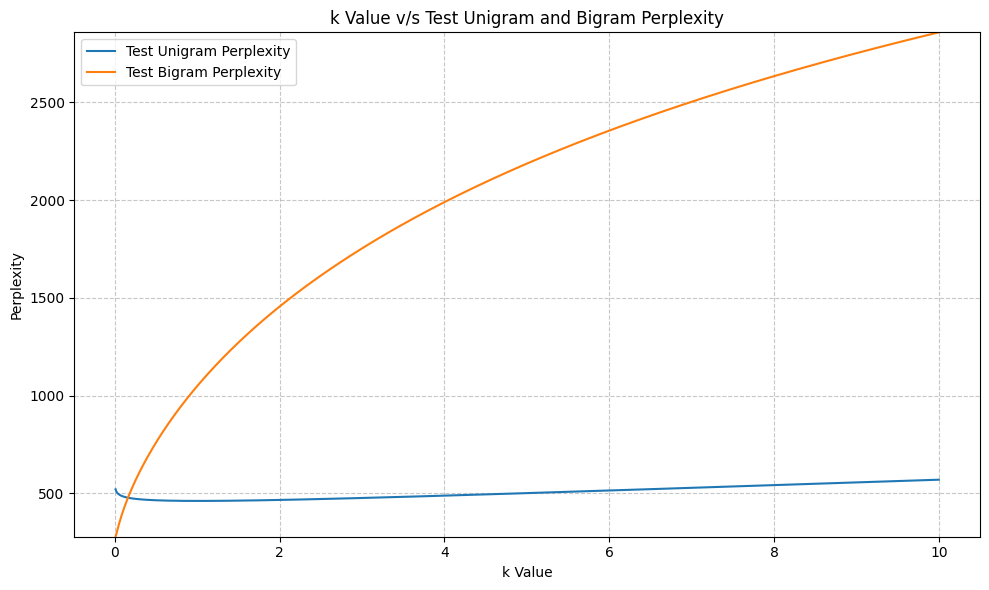

In [11]:
# Create the plot
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Plot both curves on the same axis
color1 = 'tab:blue'
color2 = 'tab:orange'
ax2.set_xlabel('k Value')
ax2.set_ylabel('Perplexity')
line1, = ax2.plot(k_vals, ugm_ppls, color=color1, label='Test Unigram Perplexity')
line2, = ax2.plot(k_vals, bgm_ppls, color=color2, label='Test Bigram Perplexity')

# Set the y-axis limits to accommodate both datasets
y_min = min(min(ugm_ppls), min(bgm_ppls))
y_max = max(max(ugm_ppls), max(bgm_ppls))
ax2.set_ylim(y_min, y_max)

# Add a title
plt.title('k Value v/s Test Unigram and Bigram Perplexity')

# Add a legend
ax2.legend(loc='upper left')

# Add a grid for better readability
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout and display the plot
fig2.tight_layout()
plt.show()